In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Data/8/20221019_175007.jpg
/content/drive/MyDrive/Data/8/20221019_175009.jpg
/content/drive/MyDrive/Data/8/20221019_175011.jpg
/content/drive/MyDrive/Data/8/20221019_175013.jpg
/content/drive/MyDrive/Data/8/20221019_175016.jpg
/content/drive/MyDrive/Data/8/20221019_175018.jpg
/content/drive/MyDrive/Data/8/20221019_175021.jpg
/content/drive/MyDrive/Data/8/20221019_175020.jpg
/content/drive/MyDrive/Data/8/20221019_175030.jpg
/content/drive/MyDrive/Data/8/20221019_175032.jpg
/content/drive/MyDrive/Data/8/20221019_175044.jpg
/content/drive/MyDrive/Data/8/20221019_175048.jpg
/content/drive/MyDrive/Data/8/20221019_175054.jpg
/content/drive/MyDrive/Data/8/20221019_175056.jpg
/content/drive/MyDrive/Data/8/20221019_175059.jpg
/content/drive/MyDrive/Data/8/20221019_175101.jpg
/content/drive/MyDrive/Data/8/20221019_175104.jpg
/content/drive/MyDrive/Data/8/20221019_175107.jpg
/content/drive/MyDrive/Data/8/20221019_175109.jpg
/content/drive/MyDrive/Data/8/20221019_175112.jpg


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
#from keras.applications import VGG19,Resnet
import cv2
import os
import random
import tensorflow as tf

In [ ]:
labels = ['5', '6','7','8','9']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data = get_data("/content/drive/MyDrive/Data")

<ipython-input-4-9e45928a5e6f>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


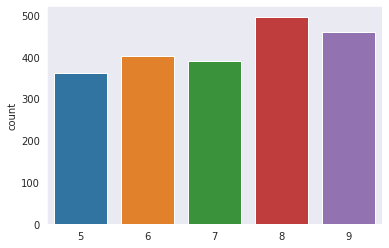

In [ ]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

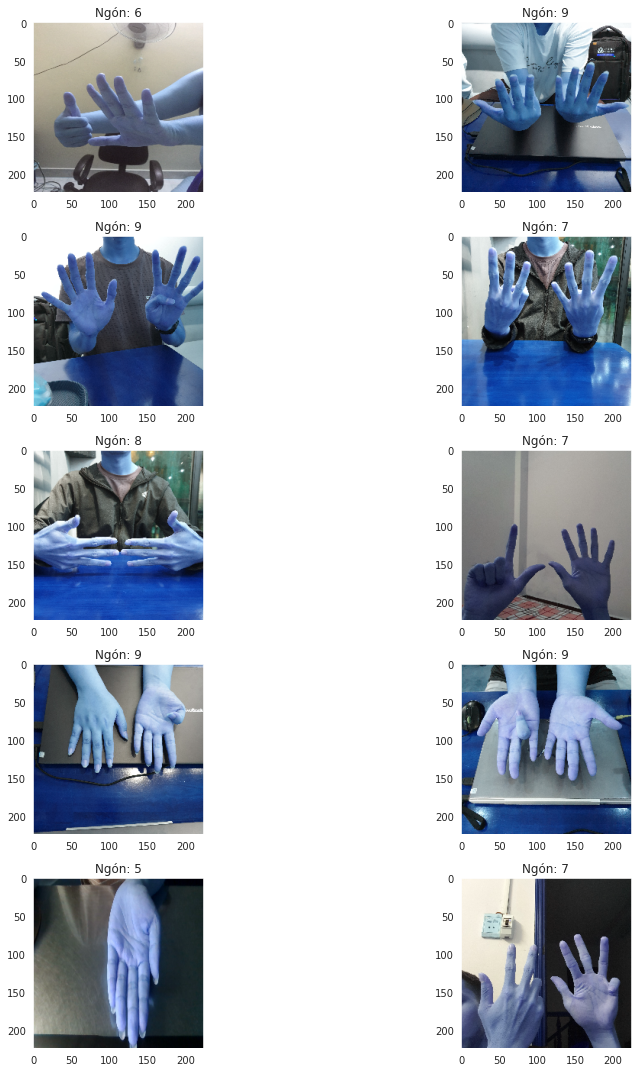

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Ngón: '+labels[data[l][1]])
        
plt.tight_layout()

In [ ]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [ ]:
# Normalize the data
x = np.array(x) / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

In [ ]:
del x,y,data

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
from keras.applications.vgg19 import VGG19
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 5)                 23045     
                                                                 
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 12 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/12
27/27 [==============================] - 31s 698ms/step - loss: 1.5022 - accuracy: 0.4076 - val_loss: 0.8362 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 2/12
27/27 [==============================] - 13s 474ms/step - loss: 0.5751 - accuracy: 0.7725 - val_loss: 0.3984 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 3/12
27/27 [==============================] - 13s 487ms/step - loss: 0.2579 - accuracy: 0.9094 - val_loss: 0.3100 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 4/12
27/27 [==============================] - 13s 498ms/step - loss: 0.1585 - accuracy: 0.9485 - val_loss: 0.2905 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 5/12
27/27 [==============================] - 13s 493ms/step - loss: 0.1064 - accuracy: 0.9573 - val_loss: 0.1402 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 6/12
27/27 [==============================] - 13s 486ms/step - loss: 0.0617 - accuracy: 0.9846 - val_loss: 0.1618 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 7/12
27/27 [==============================] - ETA: 0s - lo

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

14/14 [==============================] - 6s 257ms/step - loss: 0.1242 - accuracy: 0.9504
Loss of the model is -  0.12418150156736374
14/14 [==============================] - 3s 182ms/step - loss: 0.1242 - accuracy: 0.9504
Accuracy of the model is -  95.03546357154846 %


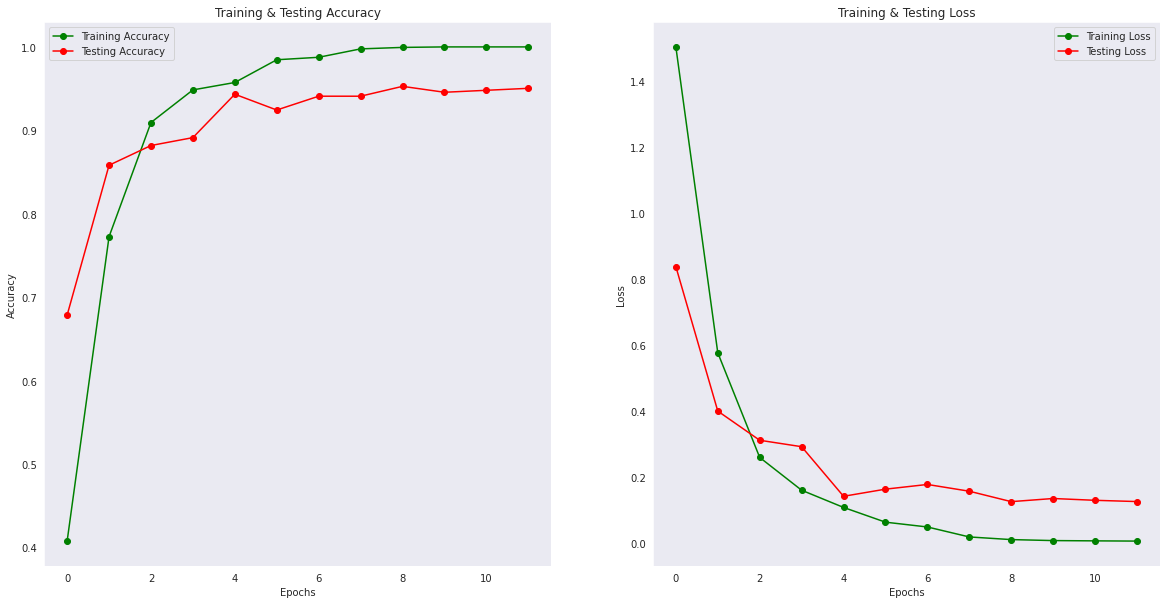

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions[:5]

In [ ]:
array([0, 2, 1, 4, 3])

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
print(classification_report(y_test_inv, predictions, target_names = labels))

In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = labels , columns = labels)

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1